In [1]:
#load Data
#https://learn.udacity.com/courses/ud980
import numpy as np
import pmdarima as pm
import yfinance as yf
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

from Quantapp.DataManager import DataManager
from Quantapp.Universe import Universe
from Quantapp.Portfolio import Portfolio
from Quantapp.Computation import Computation
from Quantapp.Algorithm import Algorithm
from Quantapp.Plot import Plot

plt.rcParams['figure.figsize'] = [15,7]

csv_file_paths = [
    'csv_files/Broad Market.csv',
    'csv_files/S&P 500.csv',
    'csv_files/Russell 1000.csv'
]

dm   = DataManager()
universe  = Universe(file_paths = csv_file_paths)
pm   = Portfolio(universe = universe)
comp = Computation()
plot = Plot()
algorithm = Algorithm()


ticker = 'AAPL'
period = '2y'
interval = '1D'

series = dm.retrieve_ticker_data(ticker, period=period, interval=interval,mode='Close')
ticker_information = universe.retrieve_asset_information(ticker).iloc[0]

sector   = ticker_information['Sector']
industry = ticker_information['Industry']
sub_industry = ticker_information['Sub-Industry']


sector_assets       = universe.retrieve_assets(Sector=sector)['Symbol']
industry_assets     = universe.retrieve_assets(Industry=industry)['Symbol']
sub_industry_assets = universe.retrieve_assets(SubIndustry=sub_industry)['Symbol']

sector_data       = dm.retrieve_multiple_ticker_data(sector_assets,period=period,interval=interval).fillna(0)
industry_data     = dm.retrieve_multiple_ticker_data(industry_assets,period=period,interval=interval).fillna(0)
sub_industry_data = dm.retrieve_multiple_ticker_data(sub_industry_assets,period=period,interval=interval).fillna(0)

sector_index      = universe.create_market_index(Sector=sector)[1:]
industry_index     = universe.create_market_index(Industry=industry)[1:]
sub_industry_index = universe.create_market_index(SubIndustry=sub_industry)[1:]

#display(ticker_information)


ModuleNotFoundError: No module named 'Quantapp'

In [ ]:
#ACF & PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(series, lags=300);
plot_pacf(series, lags=300);

In [ ]:
#AUTO ARIMA
max_p = 15
max_d = 3
max_q = 3
look_forward_period = 100


#split train / test data
X= series
size = int(len(X)*.70)
y_train, y_test = X[0:size], X[size:len(X)]
test_data = X.iloc[size:len(X)]

# fit stepwise auto-ARIMA
model   = pm.auto_arima(y_train, start_p=1, start_d=1, start_q=1,
                                 max_p=15  ,max_d=3 ,max_q=80, trace=True)


n_periods = 14
output = pd.Series(data = model.predict(n_periods=look_forward_period), index = y_test.index[:look_forward_period])

look_forward = y_test.tolist()
for t in range (n_periods-1):
   look_forward.append(output[t])


pd.Series(y_train).plot()
pd.Series(y_test).plot()
output.plot()
#pd.Series(X).plot()




In [ ]:
#ARIMA MODELS?
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
from pandas.tseries.offsets import BDay
from datetime import datetime

series_ = yf.Ticker(ticker).history(period='10y', interval='1d')['Close'].resample('W').last()
result = STL(series_).fit()
chart = result.plot()
plt.show()

In [ ]:
#gARCH MODELS
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
from pandas.tseries.offsets import BDay
from arch import arch_model

plt.plot(look_forward)
plt.plot(y_test.tolist())
series = yf.Ticker(ticker).history(period='1y', interval='1d')['Close']

returns = 100 * series.pct_change().dropna()
am =  arch_model(returns, vol="GARCH", p=1, o=0, q=1, dist="Normal")
res = am.fit(update_freq=5, disp="off")#print(res.summary())

#ax = returns.plot()
#xlim = ax.set_xlim(returns.index.min(), returns.index.max())
fig = res.plot(annualize="D")
forecasts = res.forecast(horizon=7,reindex=False)
h = forecasts.residual_variance.values.tolist()[0]
#plt.plot(series)
plt.plot(h)


100%|██████████| 133/133 [00:23<00:00,  5.73it/s]


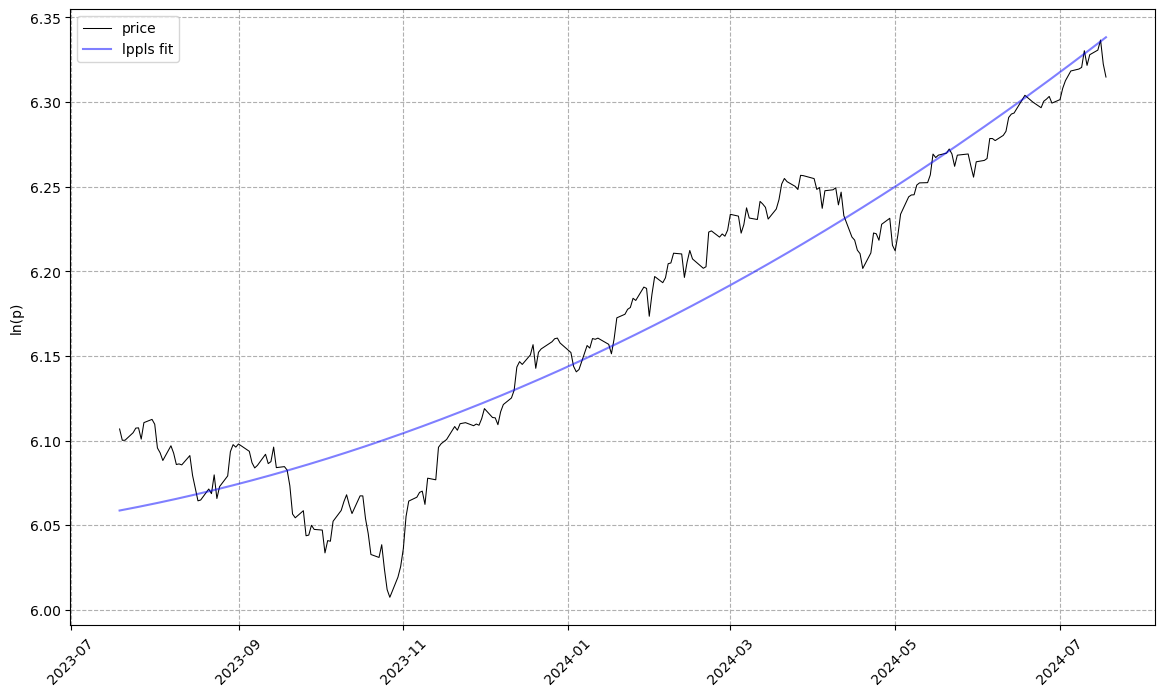

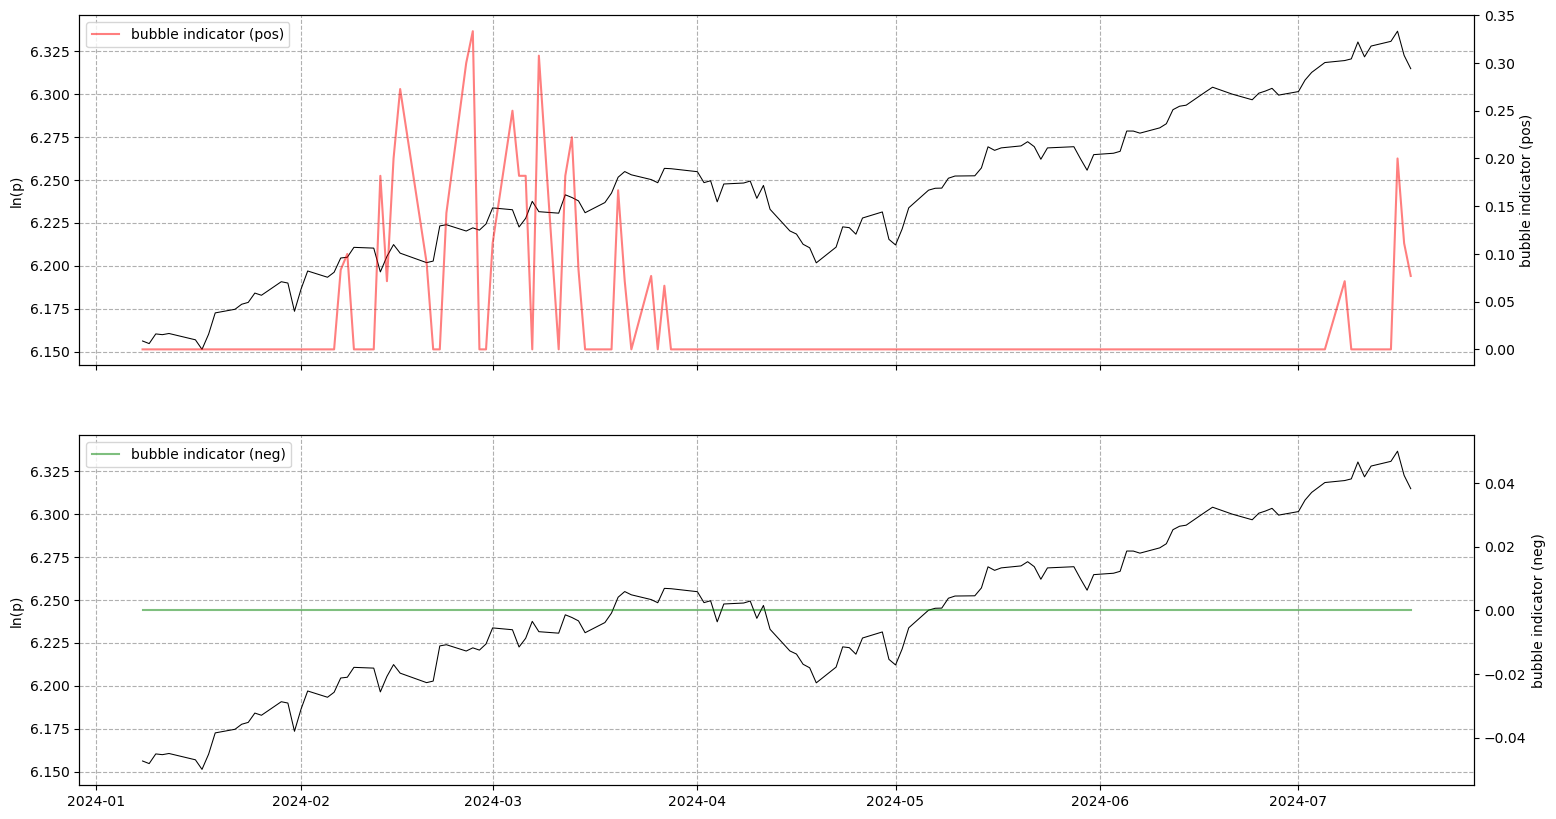

In [2]:
#LPPLS MODEL
from lppls import lppls, data_loader
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
%matplotlib inline
ticker = 'spy'
# read example dataset into df 
#data = data_loader.nasdaq_dotcom()
data = yf.Ticker(ticker).history(period='1y')
data['Date'] = pd.to_datetime(data.index).strftime("%Y-%m-%d")
# convert time to ordinal
time = [pd.Timestamp.toordinal(dt.strptime(t1, '%Y-%m-%d')) for t1 in data['Date']]

# create list of observation data
price = np.log(data['Close'].values)

# create observations array (expected format for LPPLS observations)
observations = np.array([time, price])

# set the max number for searches to perform before giving-up
# the literature suggests 25
MAX_SEARCHES = 25

# instantiate a new LPPLS model with the Nasdaq Dot-com bubble dataset
lppls_model = lppls.LPPLS(observations=observations)

# fit the model to the data and get back the params
tc, m, w, a, b, c, c1, c2, O, D = lppls_model.fit(MAX_SEARCHES)

# visualize the fit
lppls_model.plot_fit()

# should give a plot like the following...

# compute the confidence indicator
res = lppls_model.mp_compute_nested_fits(
    workers=8,
    window_size=120, 
    smallest_window_size=30, 
    outer_increment=1, 
    inner_increment=5, 
    max_searches=25,
    # filter_conditions_config={} # not implemented in 0.6.x
)

lppls_model.plot_confidence_indicators(res)
# should give a plot like the following...

In [ ]:
#Vol models
from volatility import volest
from volatility import models

import yfinance as yf

# data
symbol = 'jpm'
bench = 'spy'
estimator = 'YangZhang'

# estimator windows
window = 30
windows = [30, 60, 90, 120]
quantiles = [0.25, 0.75]
bins = 100
normed = True


# use the yahoo helper to correctly format data from finance.yahoo.com
jpm_price_data = yf.Ticker(symbol).history(period="1y")
jpm_price_data.symbol = symbol
spx_price_data = yf.Ticker(bench).history(period="1y")
spx_price_data.symbol = bench

# initialize class
vol = volest.VolatilityEstimator(
    price_data=jpm_price_data,
    estimator=estimator,
    bench_data=spx_price_data
)

# call plt.show() on any of the below...
_, plt = vol.cones(windows=windows, quantiles=quantiles)
_, plt = vol.rolling_quantiles(window=window, quantiles=quantiles)
_, plt = vol.rolling_extremes(window=window)
_, plt = vol.rolling_descriptives(window=window)
_, plt = vol.histogram(window=window, bins=bins)

_, plt = vol.benchmark_compare(window=window)
_, plt = vol.benchmark_correlation(window=window)
# ... or create a pdf term sheet with all metrics in term-sheets/
#vol.term_sheet(
#    window,
#    windows,
#    quantiles,
#    bins,
#    normed
#)

In [ ]:
#GARCH MODELS
import numpy as np
from arch import arch_model
from Quantapp.DataManager import DataManager
from Quantapp.Computation import Computation
from Quantapp.Algorithm import Algorithm

import plotly.express as px
import pandas as pd

dm   = DataManager()
comp = Computation()
algorithm = Algorithm()

data      = dm.retrieve_ticker_data(ticker='spy')['Close'].pct_change().dropna()
data_full = dm.retrieve_ticker_data(ticker='spy')

# Create a GJR-GARCH model with normal innovations
garch = arch_model(data, mean="Constant", vol="Garch", p=1, q=1, dist="normal")
egarch = arch_model(data, mean="Constant", vol="EGARCH", p=1, q=1, dist="normal")
yang_zhang = comp.rolling(algorithm.yang_zhang_volatility, 21, data_full)

def reshape(arr):
    return [x[0] for x in arr]

# Fit the model to your data
garch_results = garch.fit()
egarch_results = egarch.fit()
# Forecast volatility using a rolling window
window_size = 30 # Use a window size of 21observations
garch_forecasts  = garch_results.forecast(horizon=1, start=window_size)
egarch_forecasts = egarch_results.forecast(horizon=1, start=window_size)
# Extract the forecasted volatility
df=pd.DataFrame({'garch':pd.Series(reshape(garch_forecasts.variance.values)), 
                'egarch':pd.Series(reshape(egarch_forecasts.variance.values))})
px.line(df).show()
px.line(yang_zhang).show()
px.line(dm.retrieve_ticker_data(ticker='spy')['Close'].pct_change(21))